## Seguimiento - Expected Goals including player positions

El objetivo de esta lección es crear un modelo que estime la probabilidad de marcar (xG) a partir de variables inherentes a datos de tracking, entre las que se encuentra la posición de los jugadores rivales. Entrenaremos una red neuronal que tendrá en cuenta estas variables:

- Posición del balón(x)
- Variable binaria que marcará si el balón estaba más cerca de la portería en el momento del disparo que el portero rival.
- Ángulo del tiro en origen
- Distancia del tiro
- Distancia en y-axis entre balón y portero
- Distancia x entre portero y balón
- Número de jugadores rivales en el triángulo que forman ambos palos y el balón
- Número de rivales que están a menos de 3 metros del balón
- Variable binaria que muestre si el tiro es de cabeza
- xG en eventing (teniendo en cuenta distancia y ángulo)

Aplicaremos el modelo -entrenado con datos de Statsbomb, tanto eventing como tracking, de la Superliga India 20-21- a datos de la EURO 2021.

In [1]:
#importing necessary libraries
from mplsoccer import Sbopen
import pandas as pd
import numpy as np
import warnings 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
import random as rn
import tensorflow as tf
import time
#warnings not visible on the course webpage
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

#setting random seeds so that the results are reproducible on the webpage
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Importación de Datos

Utilizaremos los datos de Statsbomb para la Superliga India (2021/2022), pues éste es el único campeonato largo del que se dispone de datos abiertos tanto de eventing como de tracking.

In [3]:
parser = Sbopen()
#get list of games during Indian Super League season
df_match = parser.match(competition_id=1238, season_id=108)

matches = df_match.match_id.unique()

shot_df = pd.DataFrame() # datos de eventing - solo nos interesan los disparos
track_df = pd.DataFrame() # guardaremos los datos de tracking de los momentos exactos de cada disparo en eventing

for match in matches:
    time.sleep(2)
    print(match)
    df_event = parser.event(match)[0]
    df_track = parser.event(match)[2]
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots['x'] = shots.x.apply(lambda cell: cell*105/120)
    shots['y'] = shots.y.apply(lambda cell: cell*68/80)
    
    df_track['x'] = df_track.x.apply(lambda cell: cell*105/120)
    df_track['y'] = df_track.y.apply(lambda cell: cell*68/80)
    
    shot_df = pd.concat([shot_df, shots])
    track_df = pd.concat([track_df, df_track])
    
shot_df.reset_index(drop=True, inplace=True)
track_df.reset_index(drop=True, inplace=True)

shot_df = shot_df.loc[shot_df["sub_type_name"] == "Open Play"]
gks_tracked = track_df.loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"]['id'].unique()
print('Número de tiros totales: {}'.format(shot_df.shape[0]))
# jugadas en cuyos frames se encuentra el portero. Tomamos solo aquellas jugadas que tengan localizado al portero
shot_df = shot_df.loc[shot_df["id"].isin(gks_tracked)]
print('Número de tiros con el portero localizado en tracking: {}'.format(shot_df.shape[0]))

3827767
3827335
3827336
3827338
3827337
3817856
3817891
3817870
3817899
3817866
3817889
3817887
3817872
3817900
3817855
3817863
3817877
3817901
3817880
3817902
3817862
3817873
3817869
3817881
3817895
3817884
3817896
3817852
3817883
3817886
3817864
3817882
3817894
3817871
3817861
3817888
3817875
3817868
3817867
3813313
3817890
3813302
3817857
3817898
3817893
3817854
3817892
3817859
3817858
3817897
3817885
3817878
3817876
3813305
3813266
3813271
3813311
3813303
3813304
3813306
3813283
3813275
3813278
3813295
3813296
3813282
3813269
3817879
3817874
3817865
3817860
3817853
3817851
3817850
3817849
3817848
3813318
3813287
3813270
3813307
3813279
3813281
3813274
3813285
3813317
3813316
3813315
3813314
3813312
3813310
3813309
3813308
3813301
3813300
3813299
3813298
3813297
3813294
3813293
3813292
3813291
3813290
3813289
3813288
3813286
3813284
3813280
3813277
3813276
3813273
3813272
3813268
3813267
3813265
3813264
Número de tiros totales: 2881
Número de tiros con el portero localizado en track

A continuación, crearemos las variables necesarias para entrenar el modelo, y que detallamos al principio del cuaderno. Se irán añadiendo como columnas en el dframe model_vars.

In [8]:
model_vars = shot_df[["id", "index", "x", "y"]]
model_vars["goal"] = shot_df.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
model_vars["goal_smf"] = model_vars["goal"].astype(object)
model_vars['x0'] = model_vars.x
model_vars["x"] = model_vars.x.apply(lambda cell: 105-cell)
# c to calculate angle and distance between ball and the goal as in Lesson 2
model_vars["c"] = model_vars.y.apply(lambda cell: abs(34-cell))
model_vars["angle"] = np.where(np.arctan(7.32 * model_vars["x"] / (model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars["x"] /(model_vars["x"]**2 + model_vars["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars["distance"] = np.sqrt(model_vars["x"]**2 + model_vars["c"]**2)

#calculating basic xG using logistic regression
def params(df):
    test_model = smf.glm(formula="goal_smf ~ angle + distance", data=df,
                               family=sm.families.Binomial()).fit()
    #print summary
    return test_model.params

def calculate_xG(sh, b):
   bsum=b[0]
   for i,v in enumerate(["angle", "distance"]):
        bsum=bsum+b[i+1]*sh[v]
   xG = 1/(1+np.exp(bsum))
   return xG

b = params(model_vars)
# Agregamos la métrica de los xG
model_vars["xg_basic"] = model_vars.apply(calculate_xG, b = b, axis=1)

def dist_to_gk(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"] # event data ID
    #check goalkeeper position (x,y) - tracking data
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    #calculate distance from event to goalkeeper position
    dist = np.sqrt((test_shot["x"] - gk_pos["x"])**2 + (test_shot["y"] - gk_pos["y"])**2)
    return dist.iloc[0]

#store distance from event to goalkeeper position in a dataframe
model_vars["gk_distance"] = shot_df.apply(dist_to_gk, track_df = track_df, axis = 1)

#ball goalkeeper y axis
def y_to_gk(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #calculate distance from event to goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["y"]]
    #calculate distance from event to goalkeeper position in y axis
    dist = abs(test_shot["y"] - gk_pos["y"])
    return dist.iloc[0]

model_vars['gk_distance_y'] = shot_df.apply(y_to_gk,track_df=track_df,axis=1)

def three_meters_away(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get all opposition's player location
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    #calculate their distance to the ball
    dist = np.sqrt((test_shot["x"] - player_position["x"])**2 + (test_shot["y"] - player_position["y"])**2)
    #return how many are closer to the ball than 3 meters
    return len(dist[dist<3])

model_vars["close_players"] = shot_df.apply(three_meters_away, track_df = track_df, axis = 1)

# jugadores dentro del triángulo balón y palos
def players_in_triangle(test_shot,track_df):
    test_shot_id = test_shot['id']
    # x e y positions de los jugadores que, siendo rivales, figuran en un determinado momento (id)
    player_position = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False][["x", "y"]]
    # chequearemos si un punto está dentro del triángulo
    
    x1 = 105 # límite campo x
    y1 = 34 - 7.32 / 2 # desde el centro de la portería hacia cada lado
    y2 = 34 + 7.32 / 2
    x2 = 105
    x3 = test_shot['x']
    y3 = test_shot['y']
    xp = player_position['x']
    yp = player_position['y']
    c1 = (x2-x1)*(yp-y1)-(y2-y1)*(xp-x1) # lado 1
    c2 = (x3-x2)*(yp-y2)-(y3-y2)*(xp-x2) # lado 2
    c3 = (x1-x3)*(yp-y3)-(y1-y3)*(xp-x3) # lado 3
    return len(player_position.loc[((c1<0) & (c2<0) & (c3<0)) | ((c1>0) & (c2>0) & (c3>0))])

model_vars["triangle"] = shot_df.apply(players_in_triangle, track_df = track_df, axis = 1)

#goalkeeper distance to goal
def gk_dist_to_goal(test_shot, track_df):
    #get id of the shot to search for tracking data using this index
    test_shot_id = test_shot["id"]
    #get goalkeeper position
    gk_pos = track_df.loc[track_df["id"] == test_shot_id].loc[track_df["teammate"] == False].loc[track_df["position_name"] == "Goalkeeper"][["x", "y"]]
    #calculate their distance to goal
    dist = np.sqrt((105 -gk_pos["x"])**2 + (34 - gk_pos["y"])**2)
    return dist.iloc[0]

model_vars["gk_dist_to_goal"] = shot_df.apply(gk_dist_to_goal, track_df = track_df, axis = 1)
#create binary varibale 1 if ball is closer to the goal than goalkeeper
model_vars["is_closer"] = np.where(model_vars["gk_dist_to_goal"] > model_vars["distance"], 1, 0)
model_vars["header"] = shot_df.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)
#store dependent variable in a numpy array
y = model_vars["goal"].values

X = model_vars[["x0", "is_closer", "angle", "distance", "gk_distance", "gk_distance_y", "triangle", "close_players", "header", "xg_basic"]].values

### Entrenamiento de la Red Neuronal

Splitearemos el dataframe en tres (60% entrenamiento, 20% validación y 20% test). Escalamos los inputs y creamos el modelo.

In [11]:
#import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Epoch 1/1000
108/108 [==============================] - 1s 3ms/step - loss: 0.1639 - accuracy: 0.8794 - val_loss: 0.1098 - val_accuracy: 0.8974
Epoch 2/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.1017 - accuracy: 0.8974 - val_loss: 0.0928 - val_accuracy: 0.8974
Epoch 3/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0937 - accuracy: 0.8974 - val_loss: 0.0894 - val_accuracy: 0.8974
Epoch 4/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0914 - accuracy: 0.8974 - val_loss: 0.0864 - val_accuracy: 0.8974
Epoch 5/1000
108/108 [==============================] - 0s 2ms/step - loss: 0.0896 - accuracy: 0.8974 - val_loss: 0.0837 - val_accuracy: 0.8974
Epoch 6/1000
108/108 [==============================] - 0s 2ms/step - loss: 0.0879 - accuracy: 0.8974 - val_loss: 0.0810 - val_accuracy: 0.8974
Epoch 7/1000
108/108 [==============================] - 0s 2ms/step - loss: 0.0862 - accuracy: 0.8980 - val_loss: 0.0790 - val_accuracy:

108/108 [==============================] - 0s 1ms/step - loss: 0.0799 - accuracy: 0.9043 - val_loss: 0.0762 - val_accuracy: 0.9113
Epoch 58/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9032 - val_loss: 0.0764 - val_accuracy: 0.9130
Epoch 59/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0800 - accuracy: 0.9032 - val_loss: 0.0766 - val_accuracy: 0.9130
Epoch 60/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9043 - val_loss: 0.0764 - val_accuracy: 0.9130
Epoch 61/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0798 - accuracy: 0.9038 - val_loss: 0.0762 - val_accuracy: 0.9130
Epoch 62/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0797 - accuracy: 0.9038 - val_loss: 0.0764 - val_accuracy: 0.9148
Epoch 63/1000
108/108 [==============================] - 0s 1ms/step - loss: 0.0797 - accuracy: 0.9049 - val_loss: 0.0764 - val_accuracy: 0.9148

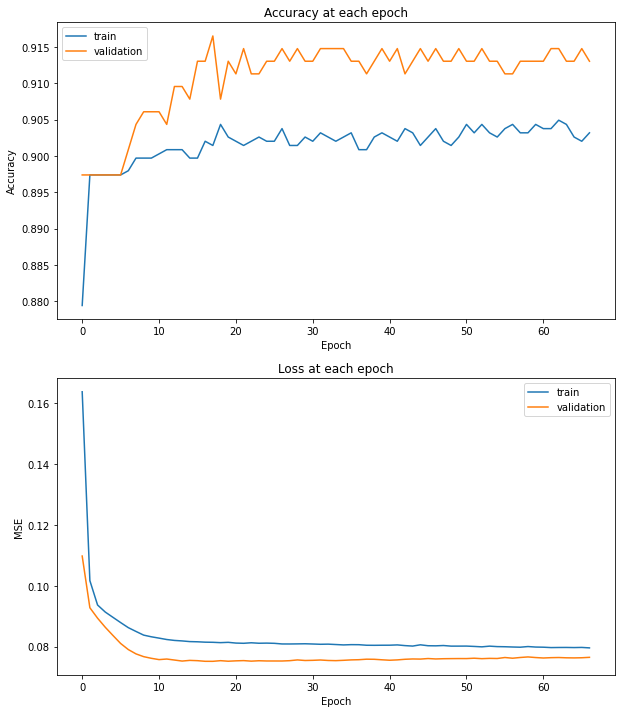

In [12]:
#spllit the data to train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 123, stratify = y)
X_cal, X_val, y_cal, y_val  = train_test_split(X_test, y_test, train_size = 0.5, random_state = 123, stratify = y_test)
#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_cal = scaler.transform(X_cal)

#creating a function with a model architecture
def create_model():
    model = Sequential([
        Dense(10, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1, activation = 'sigmoid'),
    ])
    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=opt, loss="mean_squared_error" , metrics=['accuracy'])
    return model

#create model
model = create_model()
#create an early stopping object
callback = EarlyStopping(min_delta=1e-5, patience = 50, mode = "min", monitor = "val_loss", restore_best_weights=True)
#fit the model

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, verbose=1, batch_size=16, callbacks = [callback])
fig, axs = plt.subplots(2, figsize=(10,12))
#plot training history - accuracy
axs[0].plot(history.history['accuracy'], label='train')
axs[0].plot(history.history['val_accuracy'], label='validation')
axs[0].set_title("Accuracy at each epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()

#plot training history - loss function
axs[1].plot(history.history['loss'], label='train')
axs[1].plot(history.history['val_loss'], label='validation')
axs[1].legend()
axs[1].set_title("Loss at each epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("MSE")
plt.show()


### Consolidando el Modelo

Para comprobar la fiabilidad y consistencia del modelo, calculamos ROC AUC y plasmamos la curva de calibración. Del modelo, podemos observar que algunas de las probabilidades reales mas altas son infraestimadas por el modelo. Calculamos el Brier Score, que siendo de 0.08, da un resultado satisfactorio.

**A Brier score of 0 means perfect accuracy, and a Brier score of 1 means perfect inaccuracy**

18/18 [==============================] - 0s 920us/step


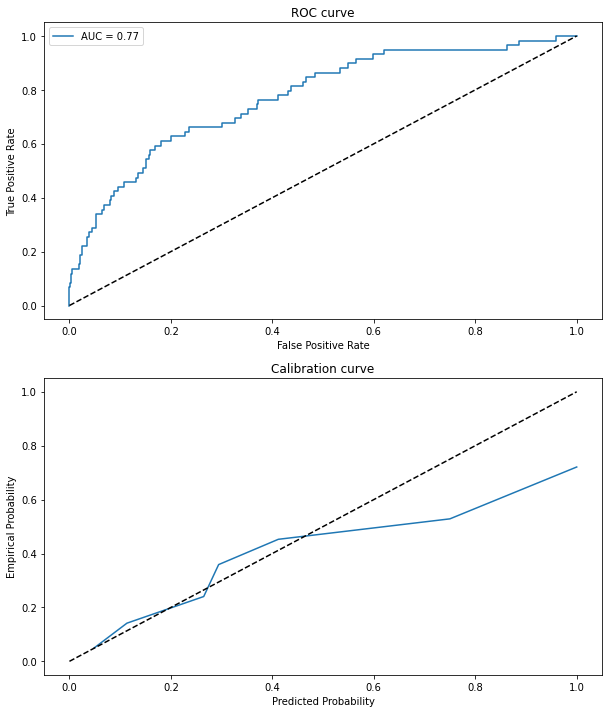

Brier score 0.08006763873614173


In [20]:
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss,accuracy_score

fig, axs = plt.subplots(2, figsize=(10,12))

y_pred = model.predict(X_cal)
fpr, tpr, _ = roc_curve(y_cal,  y_pred)
auc = roc_auc_score(y_cal, y_pred)

axs[0].plot(fpr,tpr,label= "AUC = " + str(auc)[:4])
axs[0].plot([0, 1], [0, 1], color='black', ls = '--')
axs[0].legend()
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_title('ROC curve')


from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_cal, y_pred, n_bins=10)
axs[1].plot(prob_true, prob_pred)
axs[1].plot([0, 1], [0, 1], color='black', ls = '--')
axs[1].set_ylabel('Empirical Probability')
axs[1].set_xlabel('Predicted Probability')
axs[1].set_title("Calibration curve")
plt.show()
#Brier score
print("Brier score", brier_score_loss(y_cal, y_pred))

### Calculando Tracking xG a partir del modelo en los datos de la Euro 2021

In [31]:
#getting trackings and events for UEFA Euro the same way as we did for Indian Super League
df_match2 = parser.match(competition_id=55, season_id=43)
#get array of match ids
matches2 = df_match2.match_id.unique()
shot_df2 = pd.DataFrame()
track_df2 = pd.DataFrame()
#for each match store shots and trackings in dataframes for the entire season
for match in matches2:
    df_event = parser.event(match)[0]
    df_track = parser.event(match)[2]
    shots = df_event.loc[df_event["type_name"] == "Shot"]
    shots.x = shots.x.apply(lambda cell: cell*105/120)
    shots.y = shots.y.apply(lambda cell: cell*68/80)
    df_track.x = df_track.x.apply(lambda cell: cell*105/120)
    df_track.y = df_track.y.apply(lambda cell: cell*68/80)

    shot_df2 = pd.concat([shot_df2, shots])
    track_df2 = pd.concat([track_df2, df_track])
    
#reset indicies and remove shots that were not open play or when the goalkeeper was not tracked
shot_df2 = shot_df2.loc[shot_df2["sub_type_name"] == "Open Play"]
shot_df2.reset_index(drop=True, inplace=True)
track_df2.reset_index(drop=True, inplace=True)
gks_tracked2 = track_df2.loc[track_df2["teammate"] == False].loc[track_df2["position_name"] == "Goalkeeper"]['id'].unique()
shot_df2 = shot_df2.loc[shot_df2["id"].isin(gks_tracked2)]

#DATA WRANGLING. DESCRIPTION OF THESE STEPS CAN BE FOUND IN FEATURE ENGINEERING PART
model_vars2 = shot_df2[["id", "index", "x", "y"]]
model_vars2["goal"] = shot_df2.outcome_name.apply(lambda cell: 1 if cell == "Goal" else 0)
model_vars2["goal_smf"] = model_vars2["goal"].astype(object)
model_vars2['x0'] = model_vars2.x
model_vars2["x"] = model_vars2.x.apply(lambda cell: 105-cell)
model_vars2["c"] = model_vars2.y.apply(lambda cell: abs(34-cell))
model_vars2["angle"] = np.where(np.arctan(7.32 * model_vars2["x"] / (model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) >= 0, np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)), np.arctan(7.32 * model_vars2["x"] /(model_vars2["x"]**2 + model_vars2["c"]**2 - (7.32/2)**2)) + np.pi)*180/np.pi
model_vars2["distance"] = np.sqrt(model_vars2["x"]**2 + model_vars2["c"]**2)
model_vars2["xg_basic"]= model_vars2.apply(calculate_xG, b = b, axis=1)
model_vars2["gk_distance"] = shot_df2.apply(dist_to_gk, track_df = track_df2, axis = 1)
model_vars2["gk_distance_y"] = shot_df2.apply(y_to_gk, track_df = track_df2, axis = 1)
model_vars2["triangle"] = shot_df2.apply(players_in_triangle, track_df = track_df2, axis = 1)
model_vars2["close_players"] = shot_df2.apply(three_meters_away, track_df = track_df2, axis = 1)
model_vars2["gk_dist_to_goal"] = shot_df2.apply(gk_dist_to_goal, track_df = track_df2, axis = 1)
model_vars2["is_closer"] = np.where(model_vars2["gk_dist_to_goal"] > model_vars2["distance"], 1, 0)
model_vars2["header"] = shot_df2.body_part_name.apply(lambda cell: 1 if cell == "Head" else 0)

#store data in a matrix
X_unseen = model_vars2[["x0", "is_closer", "angle", "distance", "gk_distance", "gk_distance_y", "triangle", "close_players", "header", "xg_basic"]].values
#scale data
X_unseen = scaler.transform(X_unseen)
xgs_euro = model.predict(X_unseen)

shot_df2["our_xG"] = xgs_euro
gr = shot_df2.groupby(["player_name"])["our_xG"].sum().sort_values(ascending = False).reset_index()
gr.head(10)

38/38 [==============================] - 0s 887us/step


,player_name,our_xG
0,Álvaro Borja Morata Martín,2.843986
1,Harry Kane,2.615588
2,Cristiano Ronaldo dos Santos Aveiro,2.379562
3,Kai Havertz,2.312685
4,Gerard Moreno Balaguero,2.243831
5,Raheem Sterling,2.218148
6,Ciro Immobile,2.118364
7,Robert Lewandowski,2.015634
8,Patrik Schick,1.969004
9,Martin Braithwaite Christensen,1.962817
